<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span><ul class="toc-item"><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Задачи-проекта" data-toc-modified-id="Задачи-проекта-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Задачи проекта</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси
## Описание задачи

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### Цель проекта
Построить модель для предсказания количества заказов такси 

### Задачи проекта
Для достижения целей проекта необходимо решить следующие задачи:
 - Загрузить данные и выполнить их ресемплирование по одному часу.
 - Проанализировать данные - определить трендовую составляющую и периодическую
 - Обучить разные модели с различными гиперпараметрами. 
 - Провести тестирование моделей на тестовой выборке размером 10% от исходной.
 - Сделать выводы и рекомендовать модель для прогнозирования

## Подготовка

Загрузим необходимые библиотеки

In [1]:
import scipy.signal.signaltools
def _centered(arr, newsize):
    # Return the center newsize portion of the array. 
    newsize = np.asarray(newsize) 
    currsize = np.array(arr.shape) 
    startind = (currsize - newsize) // 2 
    endind = startind + newsize 
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))] 
    return arr[tuple(myslice)] 

scipy.signal.signaltools._centered =_centered

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.signal.signaltools import _centered
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV, ParameterGrid
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

Закгрузим файл исходных данных, при этом сразу распарсим дату и установим её как индекс

In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Вывведем информацию о таблице

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


И выведем первые 5 строк

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Пропусков в таблице нет, столбцы соответствуют заявленным. В талице 26496 записи. Проверим индекс (дату) на монотонность

In [6]:
df.index.is_monotonic

True

Построим график исходных данных по заказам

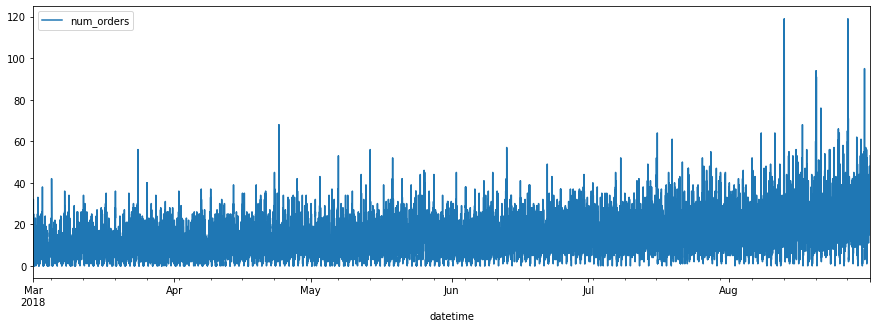

In [7]:
df.plot(figsize=(15,5));

Почасовой график заказов имеет некоторый тренд на повышение и некоторую переодичность, где пики сменяются минимумами.

### Вывод
Файл открылся без проблем, колонки соответствуют описанию. Пропусков нет. К-во записей - 26496. Индекс - дата + время с периодичностью 10 минут. Индекс монотонен.

## Анализ

Проведём ресемплирование по часам

In [8]:
df = df.resample('1H').sum()

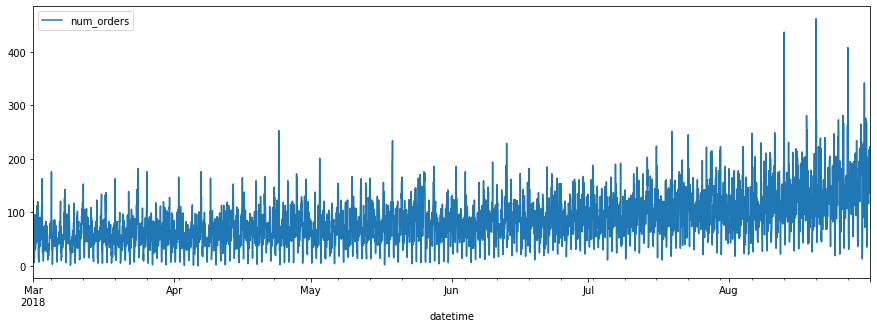

In [9]:
df.plot(figsize=(15,5));

Виден явный тренд на повышение. Что касается переодичной составляющей - попробуем вывести данные за месяц, чтобы лучше рассмотреть 

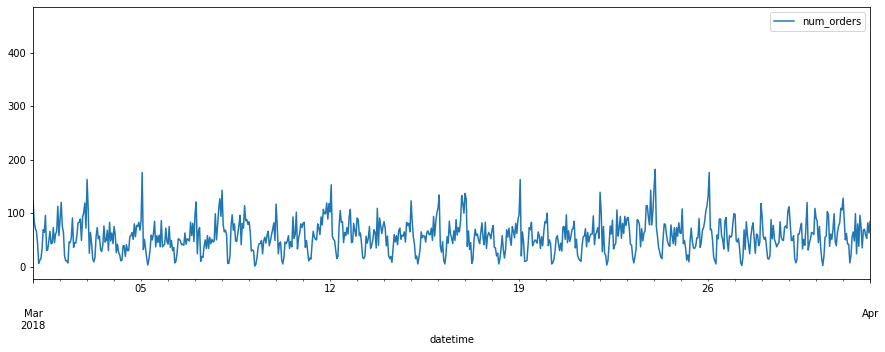

In [10]:
df.plot(figsize=(15,5), xlim=('2018-03-01','2018-04-01'));

Из графика видно, что есть периоды высоких значений и низких. Периодичность явно присутствует. Выведем данные за три дня.

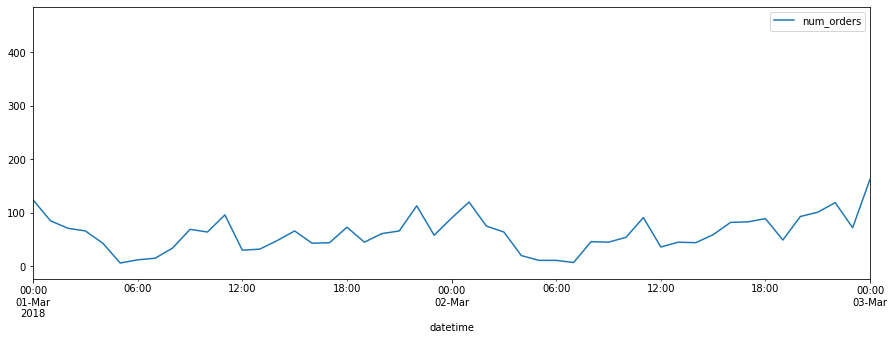

In [11]:
df.plot(figsize=(15,5), xlim=('2018-03-01','2018-03-03'));

Видно, что максимальные значения наблюдаются часов в 11.00, а минимальное в районе 6.00. Периодичность примерно сутки. Выделим составляющи.

In [12]:
decomposed = seasonal_decompose(df, period = 240) 

Посмотрим на тренд

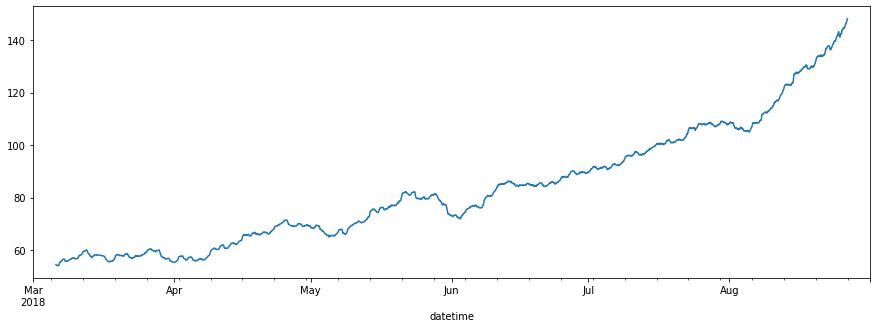

In [13]:
decomposed.trend.plot(figsize=(15,5));

Действительно есть явный тренд на повышение, хоть и колблющийся. Посмотрим на периодическую составлющую. Ограничимся 5 днями

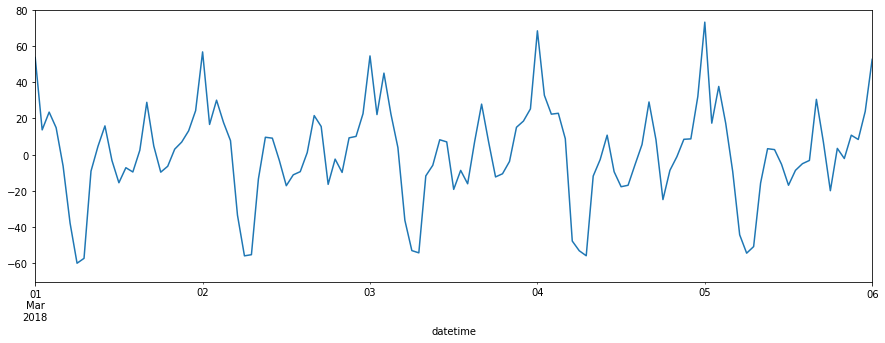

In [14]:
decomposed.seasonal.plot(figsize=(15,5), xlim=('2018-03-01','2018-03-6'));

Посмотрим на остаток

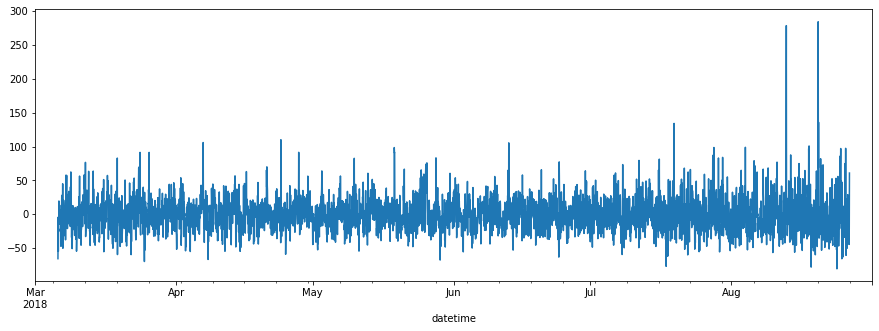

In [15]:
decomposed.resid.plot(figsize=(15,5));

### Выводы

Ряд имеет тренд на повышение с течением времени и наблюдается некоторая периодичная составляющая с периодом сутки.

## Обучение

Копируем исходный датафрэйм

In [16]:
X = df.copy()

Объявим функцию ,которая будет добавлять доп. характеристики в фрейм

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Функция добавляет в фрейм номер часа, дня, неделю, смещения и скользящее среднее 
    '''
    data['hour'] = data.index.hour
    data['day'] = data.index.dayofweek
    data['week'] = data.index.week
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Создадим доп. характеристики

In [18]:
make_features(X,2,24)

/tmp/ipykernel_54/1785271944.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = data.index.week


Выведем итоговый фрейм

In [19]:
X.head()

,num_orders,hour,day,week,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,0,3,9,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,9,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,9,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,9,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,9,66.0,71.0,NaN


Удалим появившиеся пропуски

In [20]:
X = X.dropna()

Выделим целевой признак - `num_orders`

In [21]:
y = X.pop('num_orders')

Разобъём выборку на тренировочную и тестовую часть. Для теста оставим 10%

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [23]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3952, 440, 3952, 440)

Для подбора параметров на кросс- валидации используем `TimeSeriesSplit`. Зададим кол-во батчей - 8

In [24]:
tss = TimeSeriesSplit(n_splits=8)

Для проекта используем модели линейной регрессии, случайного леса и LightGBM, которые будем записывать в *result_models*

In [25]:
result_models = []

Значение метрики *RMSE* на тренировочной выборке будем записывать в *train_score*, а на тестовой - в *test_score*

In [26]:
train_score = []

In [27]:
test_score = []

### Линейная регрессия

Используем модель линейной регресии

In [28]:
model = LinearRegression()

Зададим параметры для перебора

In [29]:
regression_grid={'fit_intercept':[True,False],'normalize':[True,False]}

In [30]:
regression_grid_search = GridSearchCV(model, regression_grid, cv=tss, scoring='neg_mean_squared_error', verbose=1,n_jobs=-1)

Запустим `GridSearch`

In [31]:
regression_grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

Выведем результаты

In [32]:
pd.DataFrame(regression_grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004695,0.002769,0.013181,0.029274,True,True,"{'fit_intercept': True, 'normalize': True}",-630.553322,-777.737942,-845.186873,-919.93873,-878.786529,-958.281134,-1246.637476,-1686.432906,-992.944364,309.096116,1
1,0.011983,0.024032,0.001721,0.000348,True,False,"{'fit_intercept': True, 'normalize': False}",-630.553322,-777.737942,-845.186873,-919.93873,-878.786529,-958.281134,-1246.637476,-1686.432906,-992.944364,309.096116,2
2,0.008933,0.017415,0.001449,0.000135,False,True,"{'fit_intercept': False, 'normalize': True}",-632.752539,-776.523777,-845.071692,-915.34612,-882.347858,-962.323480,-1246.567634,-1683.044972,-992.997259,307.854806,3
3,0.002316,0.000188,0.001544,0.000182,False,False,"{'fit_intercept': False, 'normalize': False}",-632.752539,-776.523777,-845.071692,-915.34612,-882.347858,-962.323480,-1246.567634,-1683.044972,-992.997259,307.854806,3


Лучший результат имеет модель с параметром `fit_intercept` равным *False*. Получим лучшую модель.

In [33]:
regression_model = regression_grid_search.best_estimator_

Оценим *RMSE* на тренировочной выборке

In [34]:
mean_squared_error(y_train, regression_model.predict(X_train), squared=False)

30.719624458789912

Метрика нас вполне устраивает. Визуализируем тренировочную выборку и прогноз

<AxesSubplot:xlabel='datetime'>

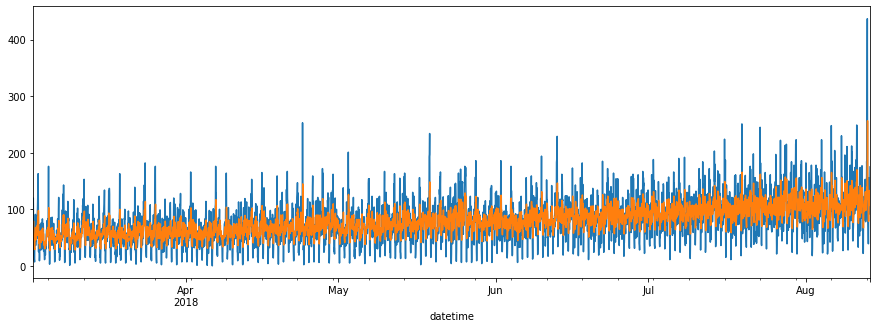

In [35]:
y_train.plot(figsize=(15,5))
pd.Series(regression_model.predict(X_train), index = y_train.index).plot()

Из графика видно, что регрессия хоть и похожа на тренировочные данные, но различия визуально довольно существенные. Модель регрессии запишем в итоговый список моделей.

In [36]:
result_models.append(regression_model)

In [37]:
train_score.append(mean_squared_error(y_train, regression_model.predict(X_train), squared=False))

### Случайный лес

Следующей моделью попробуем `RandomForestRegressor`

In [38]:
model=RandomForestRegressor(random_state = 42)

Зададим параметры поиска

In [39]:
forest_grid={'max_depth':[10, 20, 50, 100],'n_estimators':[10, 20, 30, 40, 50]}

In [40]:
forest_grid_search = GridSearchCV(model, forest_grid, cv=tss, scoring='neg_mean_squared_error')

Запустим поиск

In [41]:
forest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 50, 100],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='neg_mean_squared_error')

Вывдем результат фреймом и отсортируем по рангу.

In [42]:
pd.DataFrame(forest_grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
19,0.270351,0.130921,0.007716,0.000415,100,50,"{'max_depth': 100, 'n_estimators': 50}",-465.476722,-442.139313,-459.671818,-546.107027,-503.608274,-522.321677,-715.155372,-987.719850,-580.275007,173.714236,1
14,0.259340,0.123058,0.007539,0.000544,50,50,"{'max_depth': 50, 'n_estimators': 50}",-465.476722,-442.139313,-459.671818,-546.107027,-503.608274,-522.321677,-715.155372,-987.719850,-580.275007,173.714236,1
9,0.259054,0.120713,0.007371,0.000498,20,50,"{'max_depth': 20, 'n_estimators': 50}",-464.586810,-442.564713,-459.986853,-551.858826,-508.054565,-521.412352,-712.775459,-984.171208,-580.676348,172.116396,3
8,0.208253,0.098481,0.006361,0.000372,20,40,"{'max_depth': 20, 'n_estimators': 40}",-469.510275,-449.370320,-460.796119,-552.518889,-506.831645,-514.224536,-719.329152,-979.506988,-581.510991,170.630108,4
18,0.214904,0.104693,0.006560,0.000478,100,40,"{'max_depth': 100, 'n_estimators': 40}",-470.677483,-448.300468,-460.544808,-543.528657,-504.668374,-515.893761,-721.083472,-987.562022,-581.532381,173.447725,5
13,0.211774,0.098418,0.006407,0.000349,50,40,"{'max_depth': 50, 'n_estimators': 40}",-470.677483,-448.300468,-460.544808,-543.528657,-504.668374,-515.893761,-721.083472,-987.562022,-581.532381,173.447725,5
7,0.157509,0.073646,0.005414,0.000401,20,30,"{'max_depth': 20, 'n_estimators': 30}",-479.374518,-464.018042,-453.113506,-562.072318,-509.624068,-519.349141,-721.909949,-989.400765,-587.357788,171.735447,7
17,0.161611,0.076233,0.005384,0.000282,100,30,"{'max_depth': 100, 'n_estimators': 30}",-480.620524,-463.040774,-453.233860,-554.560780,-510.634133,-519.953974,-725.960549,-994.886004,-587.861325,173.792323,8
12,0.157733,0.073298,0.005515,0.000364,50,30,"{'max_depth': 50, 'n_estimators': 30}",-480.620524,-463.040774,-453.233860,-554.560780,-510.634133,-519.953974,-725.960549,-994.886004,-587.861325,173.792323,8
4,0.196474,0.078463,0.006278,0.000174,10,50,"{'max_depth': 10, 'n_estimators': 50}",-466.653809,-443.982441,-443.761857,-559.726337,-498.745896,-535.222140,-723.390761,-1033.132498,-588.076967,188.512382,10


Лучший результат дали модели с глубиной 50 и 100 и к-вом деревьев 50. 

In [43]:
forest_model = forest_grid_search.best_estimator_

Оценим *RMSE* на тренировочной выборке

In [44]:
mean_squared_error(y_train, forest_model.predict(X_train), squared=False)

8.50284343366911

Результат лучше чем для регрессии. Визуализируем результат сравнением 2-х графиков

<AxesSubplot:xlabel='datetime'>

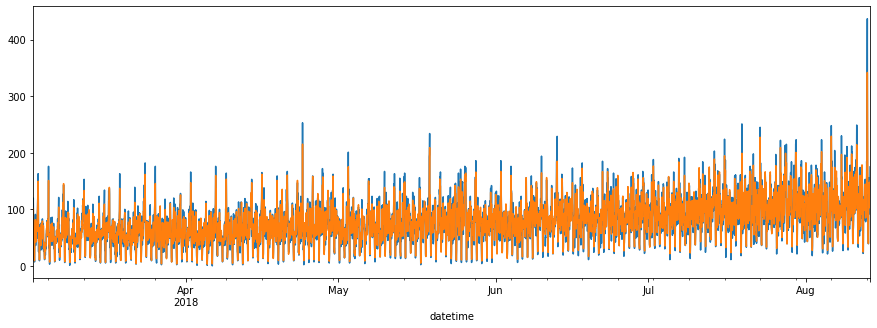

In [45]:
y_train.plot(figsize=(15,5))
pd.Series(forest_model.predict(X_train), index = y_train.index).plot()

Результат уже лучше линейной регрессии. Об этом свидетельствует меньшее значение метрики и графическое представление

In [46]:
result_models.append(forest_model)

In [47]:
train_score.append(mean_squared_error(y_train, forest_model.predict(X_train), squared=False))

### LightGBM

Создадим модель на основе `LGBMRegressor`

In [49]:
model = LGBMRegressor(random_state=42, metric='rmse')

Зададим параметры для поиска

In [50]:
lgbm_grid={'max_depth':[10, 20],'n_estimators':[30, 40, 50]}

Объявим поиск на кросс-валидации и запустим

In [51]:
lgbm_grid_search = GridSearchCV(model, lgbm_grid, cv=tss, scoring='neg_mean_squared_error')

Запустим

In [52]:
lgbm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(metric='rmse', random_state=42),
             param_grid={'max_depth': [10, 20], 'n_estimators': [30, 40, 50]},
             scoring='neg_mean_squared_error')

Выведем результаты и отсортируем по лучшей метрике

In [53]:
pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
2,0.461473,0.186073,0.037769,0.043065,10,50,"{'max_depth': 10, 'n_estimators': 50}",-441.459985,-431.837069,-433.719345,-583.286412,-492.578443,-529.132463,-713.425473,-1000.942484,-578.297709,182.946784,1
5,0.298494,0.083195,0.014041,0.029250,20,50,"{'max_depth': 20, 'n_estimators': 50}",-442.958511,-438.500744,-440.578160,-576.459989,-499.901296,-516.430260,-710.575188,-1017.412150,-580.352037,186.107691,2
1,0.477730,0.658072,0.058601,0.043155,10,40,"{'max_depth': 10, 'n_estimators': 40}",-434.385707,-435.001230,-439.360635,-578.854166,-486.200875,-521.147763,-729.459500,-1030.670520,-581.885050,193.547282,3
4,0.261063,0.065603,0.025637,0.039064,20,40,"{'max_depth': 20, 'n_estimators': 40}",-434.104791,-435.767653,-442.574276,-575.492746,-499.072615,-513.145354,-724.694396,-1057.723239,-585.321884,200.294375,4
0,2.739984,6.619380,0.003051,0.000173,10,30,"{'max_depth': 10, 'n_estimators': 30}",-429.593471,-438.854074,-451.989464,-593.722239,-488.635295,-537.148237,-752.403607,-1101.772655,-599.264880,214.564588,5
3,0.189274,0.057834,0.036321,0.043147,20,30,"{'max_depth': 20, 'n_estimators': 30}",-429.593471,-438.559153,-452.181989,-592.766835,-497.484912,-531.320739,-750.092610,-1121.608736,-601.701056,219.889323,6


Из таблицы видно, что лучший результат дала модель с глубиной 10 и к-вом деревьев 50. 

In [54]:
lgbm_model = lgbm_grid_search.best_estimator_

Оценим *RMSE* на тренировочной выборке

In [55]:
mean_squared_error(y_train, lgbm_model.predict(X_train), squared=False)

18.07827229580394

Результат несколько хуже леса, но и деревьев не 50, а 40.Визуализируем результат

<AxesSubplot:xlabel='datetime'>

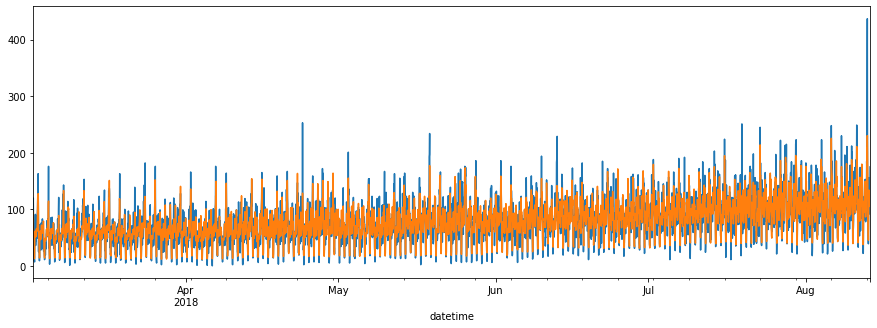

In [56]:
y_train.plot(figsize=(15,5))
pd.Series(lgbm_model.predict(X_train), index = y_train.index).plot()

Результат лучше линейной регрессии на тренировочной выборке, но несколько хуже случайного леса. Запишем результаты

In [57]:
result_models.append(lgbm_model)

In [58]:
train_score.append(mean_squared_error(y_train, lgbm_model.predict(X_train), squared=False))

### Выводы
Провели обучение 3-х моделей: линейной регрессии, случайного леса и LightGBM с перебором некоторых параметров. На тренировочной выборке модели расположились в следю порядке по возрастани метрики - Случайный лес, LightGBM, линейная регрессия

## Тестирование

Проведём тестирование моделей. 

Модель - LinearRegression(normalize=True)
RMSE на тестовой выборке 52.145179574203866


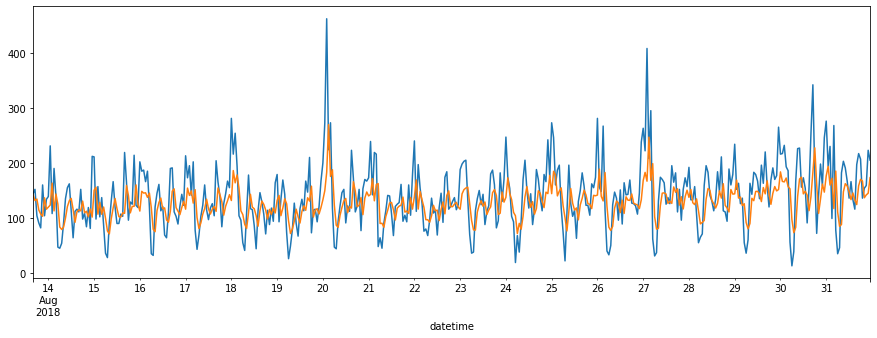

Модель - RandomForestRegressor(max_depth=50, n_estimators=50, random_state=42)
RMSE на тестовой выборке 46.05335362381333


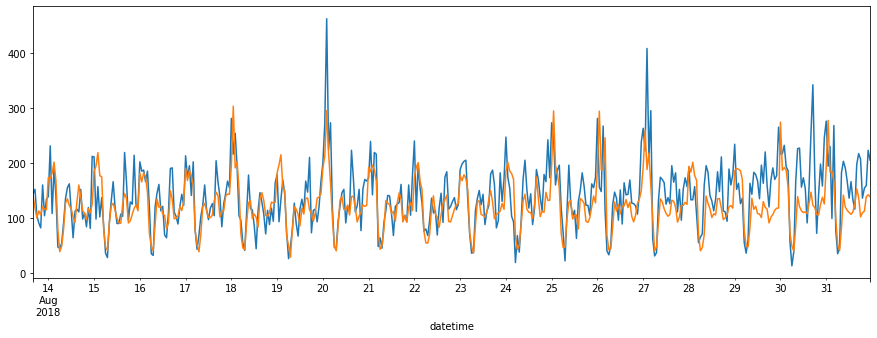

Модель - LGBMRegressor(max_depth=10, metric='rmse', n_estimators=50, random_state=42)
RMSE на тестовой выборке 44.937223313748106


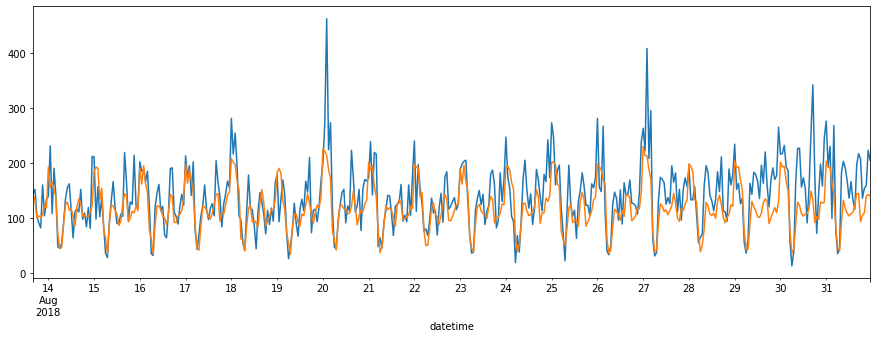

In [59]:
for model in result_models:
    test_score_ = mean_squared_error(y_test, model.predict(X_test), squared=False)#определяем метрку
    print('Модель - {}\nRMSE на тестовой выборке {}'.format(model, test_score_))
    test_score.append(test_score_ )
    y_test.plot(figsize=(15,5))#строим график для визуализации
    pd.Series(model.predict(X_test), index = y_test.index).plot()
    plt.show()

На тестовой выборке лучший результат показала модель LightGBM

In [60]:
pd.DataFrame(
    {'model':['LinearRegresson', 'RandomForestRegressor', 'LGBMRegressor'], 
     'train_score':train_score, 
     'test_score':test_score}).sort_values(by='test_score')

,model,train_score,test_score
2,LGBMRegressor,18.078272,44.937223
1,RandomForestRegressor,8.502843,46.053354
0,LinearRegresson,30.719624,52.145180


### Выводы
Модели случайного леса и LightGBM уложились в заданную метрику (менне 48). Модель регрессии показала метрику выше заданной. Для улучшения регрессии вероятно следует увеличить к-во лагов или добавить разности значений. Или вообще проверить на стационарность кого-нибудь порядка. Следует отметить, что (сходя из графиков) первые две модели ухудшают свой прогноз к концу горизонта прогнозирования (разница между фактическим и предсказываемым значением увеличивается). Для линейной регресии - расхождение более стабильно. Вероятно наилучшим решением будет использовать гибридные модели регрессия + LightGBM

## Общие выводы
- При выполнении проекта выполнили их ресемплирование по одному часу, проанализировали данные - определили составляющие и установили, что наблюдается периодичность в заказах с периодом сутки и имеется тренд на повышение к-ва заказов с течением времени. 
- Добполнили датасет признаками часа, дня и недели, сдвигов и скользящего среднего.
- Обучили и определили лучшие параметры из списка для моделей линейной регрессии, случайного леса и LightGBM. 
- Провели тестирование моделей и определили, модель линейной регресии не удовлетворяет требованиям по метрике *RMSE*

По результатам работы можем рекомендовать модель на основе для LightGBM для использования в задаче прогнозирования